In [1]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()
from tqdm import tnrange
from tqdm import trange

In [2]:
%matplotlib inline
from collections import OrderedDict
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time
import random as rand
import math
from math import exp
from mpl_toolkits.mplot3d import Axes3D as plt3d
import numpy as np
import time
#fig, ax = plt.subplots(figsize=(20,10))

In [5]:
def distance(atom1, atom2):
    #gives distance between atom
    return ((atom1.x - atom2.x)**2 + (atom1.y - atom2.y)**2)**(1/2)

class Ensemble():
    #basically a numpy array containing objects but with more functionalities
    def __init__(self, N = 1, lim = (20, 20), T = 300):
        self.configuration = np.array([])
        self.lim = lim
        self.T = T
        self.B = ((1.38064852e-23) * T)**-1
        #for i in range(N):
        #    self.Spawn(N)
        for i in range(N):
            self.Spawn_Diatomic(N)
        #during sampling, any accepted configuration will have its energy sotred in this list.
        self.configuration_total_energies = np.array([self.Energy_Total()])
    def __getitem__(self, key):
        return self.configuration[key]
    
    def __setitem__(self, key, value):
        self.configuration[key] = value

    def append(self, value):
        self.configuration = np.append(self.configuration, value)
    
    def Distance(self, atom1, atom2):
    #gives distance between atom
        return ((atom1.x - atom2.x)**2 + (atom1.y - atom2.y)**2)**(1/2)
    
    def Check_VDW_Collision(self, testAtom, atom, k = 1):
        '''
        Parameters: k is a scaling factor for collision
        returns True if there exists a atom within testAtom's vdw radius
        '''
        return self.Distance(testAtom, atom) <= (testAtom.vdw + atom.vdw)*k
    
    def Spawn(self, N):
        #deprecated
        for attempt in range(N+50):
            testAtom = Atom(rand.uniform(0, self.lim[0]), rand.uniform(0, self.lim[1]))
            if not any((testAtom.x, testAtom.y) == (atom.x, atom.y) or self.Check_VDW_Collision(testAtom, atom) for atom in self.configuration):
                self.configuration = np.append(self.configuration, testAtom)
                #print("INITIAL:", (testAtom.x, testAtom.y))
                break

        else:
            print("Failed to spawn!")
            return None
        return None
    
    def Spawn_Diatomic(self, N):
        pos1 = np.array((rand.uniform(0+10, self.lim[0]-10), rand.uniform(0+10, self.lim[1]-10)))
        dx = rand.uniform(-2.666, 2.666)
        pos2 = np.array((pos1[0]+dx,(2.666**2-(dx)**2)**0.5+pos1[1]))
        
        
        self.configuration = np.append(self.configuration, Diatomic({0: pos1, 1: pos2}))
    
    def Calculate_VDW(self):
        #pairwise calculation & i != j
        for i in self.configuration:
            i.V = 0
            for j in self.configuration:
                if i == j:
                    continue
                d = np.linalg.norm(i.getPosc() - j.getPosc())
                #Lorentz-Berthelot mixing rule
                si = (i.sigma + j.sigma)/2 
                ep = (i.epsilon * j.epsilon)**1/2
                i.V += (4 * ep * ((si/d)**12 - (si/d)**6)) #joules
    
    def Energy_Total(self):
        self.Calculate_VDW()
        return sum(atom.V for atom in self.configuration)
    
    def AcceptanceRule(self, Uo, Ut):
        #Canonical acceptance function
        try:
            return min(1, exp((-1)*self.B*(Ut - Uo)))
        except OverflowError:
            print("Overflow error! - Ensemble.AcceptanceRule()")
            return 1
    
    def Cycle(self):
        particle = self.configuration[rand.randint(0, len(self.configuration) - 1)] #select random particle
        pos_old = particle.pos
        if rand.uniform(0, 1.0) < 0.5: #50% chance for translation
            #translation
            #print("Translation")
            pos_trial = particle.Translate(self.configuration, self.lim)
        else:
            #rotation
            #print("Rotation")
            pos_trial = particle.Rotate(self.configuration, self.lim)
            
        Uo = self.Energy_Total() # Uo is total system of OLD/current configuration
        particle.pos = pos_trial 
        Ut = self.Energy_Total()
        if rand.uniform(0,1) < self.AcceptanceRule(Uo, Ut):
            #accept Ut
            self.configuration_total_energies = np.append(self.configuration_total_energies, Ut)
            return
        else:
            #reject Ut
            particle.pos = pos_old
            #could it be double-counting if this is uncommented?
            #self.configuration_total_energies = np.append(self.configuration_total_energies, Uo)
    
    def Cycle_deprecated(self):
        atom = self.configuration[rand.randint(0, len(self.configuration) - 1)] #in the current configuration (system), select a random atom
        #rigid translation
        low = -0.01
        high = 0.01
        xo = atom.x #old/current x of the selected atom
        yo = atom.y
        xt = atom.x + rand.uniform(low, high) #x trial
        yt = atom.y + rand.uniform(low, high) #y trial
        #print("xt: {0}, yt: {1}".format(xt, yt))
        #print(abs(xo-xt), abs(yo-yt))

        while True:
            while xt < 0 or xt > self.lim[0]:
                #print('2')
                xt = atom.x + rand.uniform(low, high)
                while any((xt, yt) == (otherAtom.x, otherAtom.y) for otherAtom in self.configuration):
                    #print('1')
                    xt = atom.x + rand.uniform(low, high) #x trial
                    yt = atom.y + rand.uniform(low, high) #y trial
            #else:
                #print('2e')
                    
            while yt < 0 or yt > self.lim[1]:
                #print('3')
                yt = atom.y + rand.uniform(low, high)
                while any((xt, yt) == (otherAtom.x, otherAtom.y) for otherAtom in self.configuration):
                    #print('1')
                    xt = atom.x + rand.uniform(low, high) #x trial
                    yt = atom.y + rand.uniform(low, high) #y trial
            #else:
                #print('3e')

            break
        
        Uo = self.Energy_Total() # Uo is total system of OLD/current configuration
        atom.x = xt #change atom coordinates to trial ones
        atom.y = yt
        Ut = self.Energy_Total()
        if rand.uniform(0,1) < self.AcceptanceRule(Uo, Ut):
            #accept Ut
            self.configuration_total_energies = np.append(self.configuration_total_energies, Ut)
            return
        else:
            #reject Ut
            atom.x = xo
            atom.y = yo
            self.configuration_total_energies = np.append(self.configuration_total_energies, Uo)

    
    def Average(self):
        #takes in an array containing energies corresponding to a sampled configuration
        #evaluates average energy by probaility weighting
        numerator = 0
        denominator = 0
        for i in range(len(self.configuration_total_energies)):
            numerator += (self.configuration_total_energies[i] * exp((-1)*self.B*self.configuration_total_energies[i]))
            denominator += exp((-1)*self.B*self.configuration_total_energies[i])
        return numerator/denominator

    def Plot(self, title = ""):
        fig, ax = plt.subplots(figsize=(20,10))
        for atom in self.configuration:
            if isinstance(atom, Diatomic):
                plt.scatter(atom.pos[0][0], atom.pos[0][1], c = "black", s = 5)
                plt.scatter(atom.pos[1][0], atom.pos[1][1], c = "red", s = 10)
                plt.plot([atom.pos[0][0], atom.pos[1][0]], [atom.pos[0][1], atom.pos[1][1]])
                ax.add_artist(plt.Circle((atom.pos[0][0], atom.pos[0][1]), atom.vdw, fill = False))
                ax.add_artist(plt.Circle((atom.pos[1][0], atom.pos[1][1]), atom.vdw, fill = False))
            else:
                plt.scatter(atom.x, atom.y, c = "black", s = 1)
                ax.add_artist(plt.Circle((atom.x, atom.y), atom.vdw, fill = False))
        plt.xlim([0, self.lim[0]])
        plt.ylim([0, self.lim[1]])
        plt.title(title)
        ax.set_aspect('equal')

class Atom():
    def __init__(self, x, y):
        '''
        '''
        #default parameters = argon
        self.kb = 1.38064852e-23
        self.mass = 1
        self.vdw = 1.83 #angstrom...just random value of previous proposed
        self.sigma = 3.465 # mourits and rummens. Can. J. Chem. 55, 3007 (1977)
        self.epsilon = 113.5*self.kb #joules, mourits and rummens. Can. J. Chem. 55, 3007 (1977)
        self.V = 0
        self.posc = np.array([x,y]) #center position, which is the same as position
        self.x = x
        self.y = y
    
    def getPosc(self):
        #redundant but creating this method so that certain lines of codes are universal regardless of
        #Atom or Diatomic type objects.
        return self.posc
        
class Diatomic():
    def __init__(self, pos):
        #default parameters = I2
        #I2 bond length = 2.666 A
        self.kb = 1.38064852e-23
        self.sigma = 4.630 #mourits and rummens. Can. J. Chem. 55, 3007 (1977)
        self.epsilon = 577.4 * self.kb #mourits and rummens. Can. J. Chem. 55, 3007 (1977)
        self.bond_length = 2.666 #Angstrom
        self.pos = pos #dictionary. key = atom, value = np.array([x_coord, y_coord])
        self.vdw = 1.98 #vdw radii of each I2
        self.V = 0 #potential energy
        self.mass = 1
        #center position
    
    def getPosc(self):
        #return center position coordinates
        return np.array([(self.pos[0][0] + self.pos[1][0])/2,(self.pos[0][1] + self.pos[1][1])/2]) 
    
    def __ccw(self, A,B,C):
        # source: https://stackoverflow.com/questions/70528/why-are-pythons-private-methods-not-actually-private
        return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

    def __If_Intersect(self, A,B,C,D):
        # source: https://stackoverflow.com/questions/70528/why-are-pythons-private-methods-not-actually-private
        # Return true if line segments AB and CD intersect
        return self.__ccw(A,C,D) != self.__ccw(B,C,D) and self.__ccw(A,B,C) != self.__ccw(A,B,D)
    
    
    def __If_Collision(self, pos_test, configuration):
        if any(np.array_equal(self.pos[0], otherParticle.pos[0]) for otherParticle in configuration if otherParticle is not self) or \
            any(np.array_equal(self.pos[1], otherParticle.pos[1]) for otherParticle in configuration if otherParticle is not self):
            print("Collision! Atom overlap")
            return True
        if any(self.__If_Intersect(self.pos[0], self.pos[1], otherParticle.pos[0], otherParticle.pos[1]) \
               for otherParticle in configuration if otherParticle is not self):
            print("Collision! Bond overlap")
            return True
        return False
    
    def Translate(self, configuration, lim):
        #return trial coordinates after translation. does not update self's coordinates
        low = -0.01
        high = 0.01
        dx = rand.uniform(low, high)
        dy = rand.uniform(low, high)
        pos_trial = {0: self.pos[0] + [dx, dy], 1: self.pos[1] + [dx, dy]}
        attempts = 0
        while self.__If_Collision(pos_trial, configuration) or \
                any(pos_trial[0] + [self.vdw, self.vdw] > lim) or any(pos_trial[1] + [self.vdw,  self.vdw] > lim) or \
                any(pos_trial[0] < [0,0]) or any(pos_trial[1] < [0,0]) or attempts < 100:
            #print("Rerolling translation coordinates")
            dx = rand.uniform(low, high)
            dy = rand.uniform(low, high)
            pos_trial = {0: self.pos[0] + [dx, dy], 1: self.pos[1] + [dx, dy]}
            attempts += 1
        return pos_trial
        
    def Rotate(self, configuration, lim):
        #returns trial coordinates after rotation. does not update self's coordinates
        cx = (self.pos[0][0] + self.pos[1][0])/2 #center x
        cy = (self.pos[0][1] + self.pos[1][1])/2 #center y
        th = rand.uniform(0, 2*math.pi) #random theta
        
        #trial x coordinate for atom 1
        x1t = ((self.pos[0][0] - cx) * math.cos(th) + (self.pos[0][1] - cy) * math.sin(th) ) + cx 
        #trial y coordinate for atom 1
        y1t = (-(self.pos[0][0] - cx) * math.sin(th) + (self.pos[0][1] - cy) * math.cos(th) ) + cy 
        
        #trial x coordinate for atom 2
        x2t = ((self.pos[1][0] - cx) * math.cos(th) + (self.pos[1][1] - cy) * math.sin(th) ) + cx 
        #trial y coordinate for atom 2
        y2t = (-(self.pos[1][0] - cx) * math.sin(th) + (self.pos[1][1] - cy) * math.cos(th) ) + cy 
        
        pos_trial = {0: np.array([x1t, y1t]), 1: np.array([x2t, y2t])}
        attempts = 0
        while self.__If_Collision(pos_trial, configuration) or \
                any(pos_trial[0] + [self.vdw, self.vdw] > lim) or any(pos_trial[1] + [self.vdw,  self.vdw] > lim) or \
                any(pos_trial[0] < [0,0]) or any(pos_trial[1] < [0,0]) or attempts < 100:
            #print("Rerolling rotation")
            th = rand.uniform(0, 2*math.pi) #random theta
        
            #trial x coordinate for atom 1
            x1t = ((self.pos[0][0] - cx) * math.cos(th) + (self.pos[0][1] - cy) * math.sin(th) ) + cx 
            #trial y coordinate for atom 1
            y1t = (-(self.pos[0][0] - cx) * math.sin(th) + (self.pos[0][1] - cy) * math.cos(th) ) + cy 

            #trial x coordinate for atom 2
            x2t = ((self.pos[1][0] - cx) * math.cos(th) + (self.pos[1][1] - cy) * math.sin(th) ) + cx 
            #trial y coordinate for atom 2
            y2t = (-(self.pos[1][0] - cx) * math.sin(th) + (self.pos[1][1] - cy) * math.cos(th) ) + cy 

            pos_trial = {0: np.array([x1t, y1t]), 1: np.array([x2t, y2t])}
            attempts += 1
        return pos_trial

def run(ncyc, N = 1, lim = (20, 20), T = 300, ensemble = None, animation = False, dframe = 0.001):
    #initialize system
    if ensemble == None:
        ensemble = Ensemble(N, lim, T)
        ensemble.Plot("Initial Configuration")
    else:
        ensemble.Plot("Initial Configuration")

    #start simulation
    y = [ensemble.Energy_Total()]
    start_time = time.time()
    for i in trange(ncyc):
        ensemble.Cycle()
        y.append(ensemble.Energy_Total())
        if animation:
            fig = ensemble.Plot()
            clear_output(wait=True) # Clear output for dynamic display
            display(fig)            # Reset display
            fig.clear()             # Prevent overlapping and layered plots
            time.sleep(dframe)
    print("Elapsed time:", time.time() - start_time, "(s)")
    print("Initial energy:", y[0], "(J)")
    print("Final energy:", y[-1], "(J)")
    print("Average energy:", ensemble.Average(),"(J)")

    ensemble.Plot("Final Configuration")
    x = range(0, len(y))
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(x,y)
    plt.xlim([0, ncyc])
    plt.ylim([min(y), max(y)])
    plt.title("Total Energy vs. Cycle")
    return ensemble

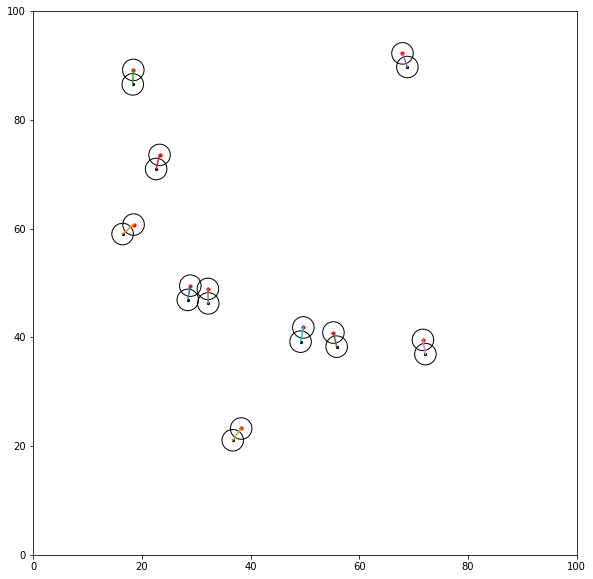

In [6]:
system = Ensemble(10, lim = (100, 100))
system.Plot()

100%|██████████| 1000/1000 [00:25<00:00, 38.84it/s]


Elapsed time: 25.74925994873047 (s)
Initial energy: 4.770898940805332e-39 (J)
Final energy: 4.4091919292040125e-39 (J)
Average energy: 4.567417733359622e-39 (J)


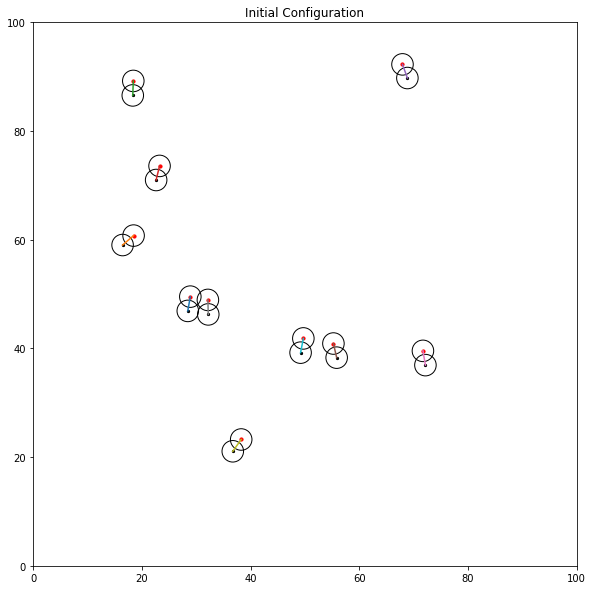

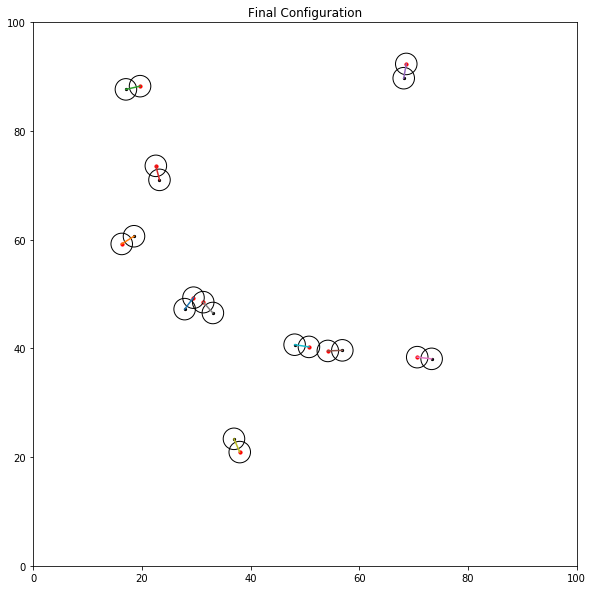

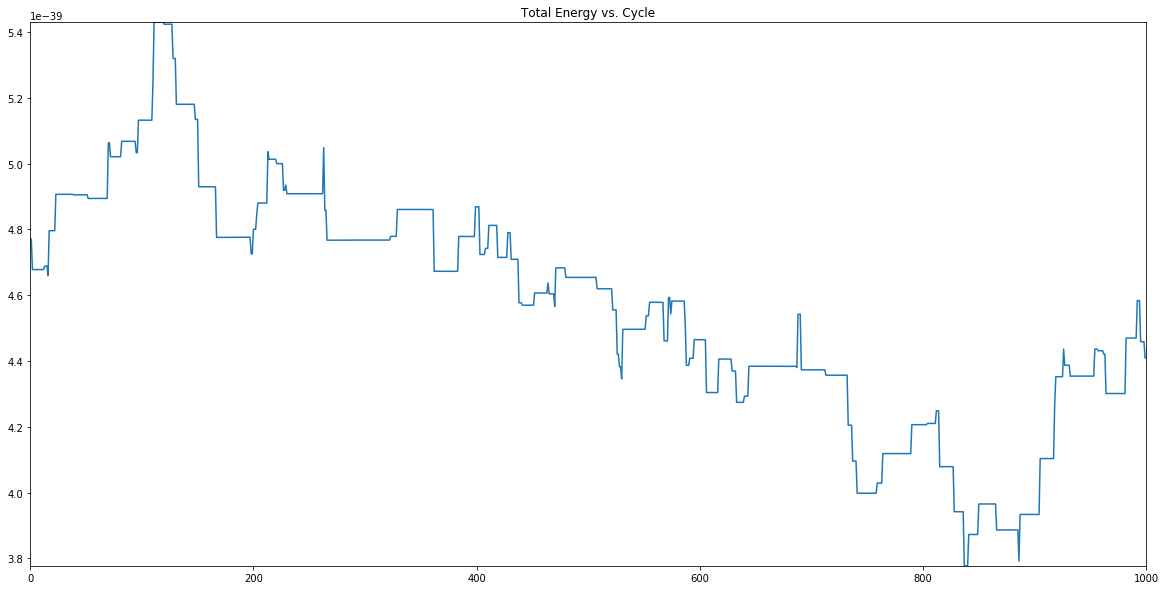

In [7]:
run(1000, ensemble = system)

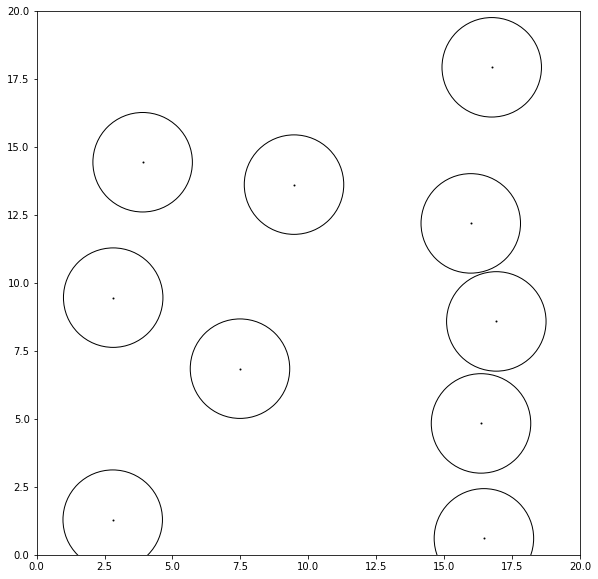

In [9]:
system2 = Ensemble(N=0)
for i in range(10):
    system2.Spawn(N = 0)
system2.Plot()

In [10]:
system2.Energy_Total()

-1.0216529615693942e-41